In [13]:
from distance.EuclideanDistance import EuclideanDistance
from utilities.visualization import Visualizer
from utilities.dataset_factory import DatasetFactory
import numpy as np
import keras
from CL_utilities import loss_function

# Hyperparameters

In [14]:
image_size = (250, 250)
epochs = 10
batch_size = 16
margin = 0.5
training_pairs = 2800
validation_pairs = 400
training_path = r"./data/FruitRecognition/Training"
validation_path = r"./data/FruitRecognition/Validation"

# Building training dataset 
# (1.) See Documentation to get info about structure of dataset

In [15]:
training_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(training_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(250, 250, 3)


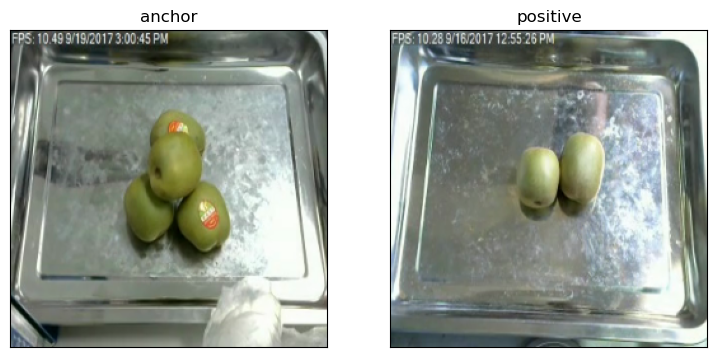

In [16]:
image, _ = next(iter(training_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

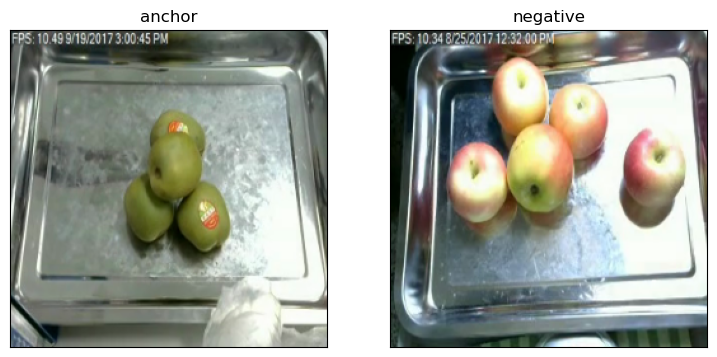

In [17]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

# Creating validation dataset

In [18]:
validation_dataset = DatasetFactory.build_dataset(ds_path=training_path,
                                                image_size=image_size,
                                                batch_size=batch_size,
                                                max_iterations=training_pairs,
                                                method="contrastive_loss")
print(validation_dataset)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


(250, 250, 3)


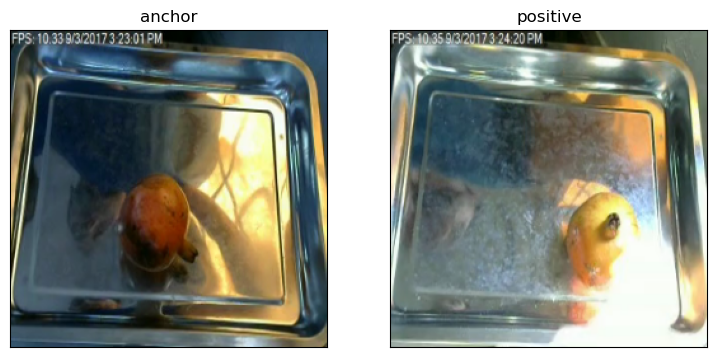

In [19]:
image, _ = next(iter(validation_dataset))
anchor_img = np.asarray(image[0][0]).astype('float32')
positive_img = np.asarray(image[1][0]).astype('float32')

Visualizer.visualize(**{"anchor": anchor_img, "positive" : positive_img})
print(anchor_img.shape)

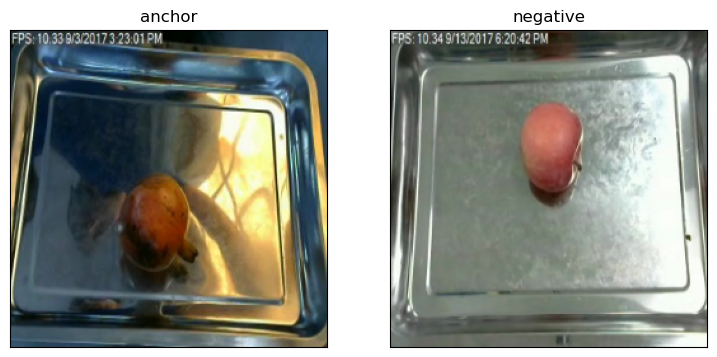

In [20]:
anchor_img = np.asarray(image[0][1]).astype('float32')
negative_img = np.asarray(image[1][1]).astype('float32')
Visualizer.visualize(**{"anchor": anchor_img, "negative" : negative_img})

In [21]:
input_layer = keras.layers.Input((250,250,3))
x = keras.layers.BatchNormalization()(input_layer)
x = keras.layers.Conv2D(32, (5,5), activation="relu")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(64, (3,3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(128, (3,3), activation="relu")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(16, activation="relu")(x)
embedding_network = keras.Model(input_layer, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu


In [22]:
input_1 = keras.layers.Input(image_size + (3,))
input_2 = keras.layers.Input(image_size + (3,))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

# euclidean_distance = 
merge_layer = keras.layers.Lambda(EuclideanDistance(), output_shape=(1,))([tower_1, tower_2])

normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [23]:
siamese.compile(loss=loss_function.loss(margin=margin), optimizer='adam', metrics=['accuracy'])
siamese.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 250, 250,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 250, 250,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_3        │ (None, 16)        │  6,985,628 │ input_layer_2[0]… │
│ (Functional)        │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_3[0][… │
│                     │                   │            │ functional_3[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,985,634 (26.65 MB)

 Trainable params: 6,985,498 (26.65 MB)

 Non-trainable params: 136 (544.00 B)

In [24]:
# How many samples we have, and how many we want in train and validation
# num_samples = sum(1 for _ in touple_of_products)
# train_size = int(0.8 * num_samples)
# val_size = num_samples - train_size
# # .take() to get from actual batch
# train_dataset = touple_of_products.take(train_size)
# val_dataset = touple_of_products.skip(train_size)

Trained_model_data = siamese.fit(training_dataset, 
                                 validation_data= validation_dataset, 
                                 batch_size = batch_size,
                                 epochs = epochs
                                )

Epoch 1/10
    350/Unknown 315s 891ms/step - accuracy: 0.6054 - loss: 0.1131

2024-05-05 21:00:05.491723: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/c100rczyk/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


350/350 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.6056 - loss: 0.1131 - val_accuracy: 0.7136 - val_loss: 0.0440
Epoch 2/10


2024-05-05 21:01:28.993624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.7276 - loss: 0.0422

2024-05-05 21:06:42.847457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.7275 - loss: 0.0422 - val_accuracy: 0.7195 - val_loss: 0.0340
Epoch 3/10


2024-05-05 21:08:06.277674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.6917 - loss: 0.0357

2024-05-05 21:13:20.493851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.6917 - loss: 0.0357 - val_accuracy: 0.7196 - val_loss: 0.0331
Epoch 4/10


2024-05-05 21:14:43.784786: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.6999 - loss: 0.0320

2024-05-05 21:19:56.979181: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.6999 - loss: 0.0320 - val_accuracy: 0.7552 - val_loss: 0.0285
Epoch 5/10


2024-05-05 21:21:20.351798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 897ms/step - accuracy: 0.7406 - loss: 0.0275

2024-05-05 21:26:34.521223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.7406 - loss: 0.0275 - val_accuracy: 0.7489 - val_loss: 0.0245
Epoch 6/10


2024-05-05 21:27:58.268464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.7393 - loss: 0.0289

2024-05-05 21:33:11.602625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.7392 - loss: 0.0289 - val_accuracy: 0.8014 - val_loss: 0.0272
Epoch 7/10


2024-05-05 21:34:35.212573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 893ms/step - accuracy: 0.7614 - loss: 0.0243

2024-05-05 21:39:47.792983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 396s 1s/step - accuracy: 0.7614 - loss: 0.0243 - val_accuracy: 0.8227 - val_loss: 0.0187
Epoch 8/10


2024-05-05 21:41:11.483923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.8029 - loss: 0.0201

2024-05-05 21:46:24.621162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.8028 - loss: 0.0201 - val_accuracy: 0.8020 - val_loss: 0.0251
Epoch 9/10


2024-05-05 21:47:48.074375: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 896ms/step - accuracy: 0.8112 - loss: 0.0196

2024-05-05 21:53:01.692968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.8112 - loss: 0.0196 - val_accuracy: 0.8041 - val_loss: 0.0197
Epoch 10/10


2024-05-05 21:54:25.882688: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 894ms/step - accuracy: 0.8415 - loss: 0.0167

2024-05-05 21:59:38.839280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


350/350 ━━━━━━━━━━━━━━━━━━━━ 397s 1s/step - accuracy: 0.8415 - loss: 0.0167 - val_accuracy: 0.8330 - val_loss: 0.0245


2024-05-05 22:01:03.231427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [27]:
# Loading Representatives from dataset_shop

camera_path = 'data/FruitRecognition/Shop_database'
paths = DatasetFactory.give_paths_to_test(camera_path, 10)

fruits_names = []
fruits_paths = []
fruits_names = [key.split('/')[-1] for key in paths.keys()]
fruits_paths = [value for value in paths.values()]  # Get 5 representatives for each class


In [28]:
#print(fruits_names)
#print(fruits_paths)

In [29]:
print((fruits_paths[0][4]))

data/FruitRecognition/Shop_database/muskmelon/Muskmelon 001223.png


In [30]:
import tensorflow as tf
from utilities.mapping import Mapper
list_of_images = []
list_of_labels = []
List_mean_feature_vector_shop = np.zeros((23,16))
i=0
j=0

for i in range(len(fruits_paths)):
    for j in range(5):
        path_to_image = Mapper(image_size)
        image = path_to_image._decode_and_resize(fruits_paths[i][j])
        list_of_images.append(image)
        list_of_labels.append(fruits_names[i])
    #print(list_of_labels)
        
    #___________________Get dimensions__________________________
    num_of_images = 5#len(list_of_images[0])  #one mean for each class
    size_feature_vector = embedding_network(tf.expand_dims(list_of_images[0], axis=0)).numpy()
    size_feature_vector = size_feature_vector.shape[1]   #get length
    #___________________________________________________________
    list_class_vectors = np.zeros((num_of_images, size_feature_vector))
        
    for num in range(5):
        list_class_vectors[num] = embedding_network(tf.expand_dims(list_of_images[num], axis=0)).numpy()
    #print(list_class_vectors)    
        
    mean_feature_vector = np.mean(list_class_vectors, axis=0)   # mean vector for all representatives of class
    
    List_mean_feature_vector_shop[i] = mean_feature_vector
    print(fruits_names[i])
    print(List_mean_feature_vector_shop[i])

    list_of_images.clear()
    list_of_labels.clear()
    
    

muskmelon
[0.55624386 0.31133067 0.02848839 0.02888919 2.13650312 2.09013264
 1.06339558 1.61192129 1.76531498 0.95349328 1.01423589 0.8567332
 1.57195618 1.13571727 0.41576799 0.19218414]
Kiwi C
[0.53657022 2.28497856 1.14968438 0.98656608 2.27235205 0.15449086
 1.94403555 0.         0.79251274 1.32977158 0.23861952 0.74576176
 0.51168488 1.17605033 0.         2.85265665]
Apple A
[0.32755507 0.         0.19525378 0.96254749 0.17150792 0.16220974
 0.12247463 0.00965753 1.00766075 1.04918422 1.84405909 2.24435496
 0.         1.07855953 1.22910621 0.85850289]
Apple C
[0.         0.29594259 0.56503665 1.51059113 0.88910553 0.07411339
 0.0435012  1.01159182 0.03333099 0.01652529 3.11945214 2.46897473
 0.02370611 0.1688999  0.72362439 0.7249262 ]
Carambola
[2.22834768 0.4091285  0.01520187 0.32705013 2.64621639 0.33704127
 1.35417607 0.84117995 1.24250761 0.05045804 0.14887173 0.05158513
 2.21369042 0.369158   0.16953671 0.12142762]
guava A
[2.47845488 1.53906331 0.15082675 1.20491408 2.515

In [31]:
def distance_between_vectors(vector1, vector2):
    vector1 = vector1 / tf.norm(vector1)   # length ov vector == 1
    vector2 = vector2 / tf.norm(vector2)
    sum_square = np.sum(np.square(vector1 - vector2))
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

In [32]:
np.set_printoptions(precision=4)

distance1 = distance_between_vectors(List_mean_feature_vector_shop[0], List_mean_feature_vector_shop[16])
distance2 = distance_between_vectors(List_mean_feature_vector_shop[7], List_mean_feature_vector_shop[20])

print(f"Distance between {fruits_names[0]} and {fruits_names[16]}  == {distance1}")
print(f"Distance between {fruits_names[7]} and {fruits_names[20]}  == {distance2}\n")



Distance between muskmelon and Tomatoes  == 1.1000747570501404
Distance between guava B and Plum  == 0.7544144963251265



In [33]:
import random

camera_images_list = []
camera_labels_list = []
path_test_eff = 'data/FruitRecognition/Test'
data = DatasetFactory.give_paths_to_test(path_test_eff, 1)


# Losowo wybieranie 10 zdjęć z każdego folderu
camera_paths = [random.sample(paths_list, 10) for paths_list in data.values() if len(paths_list) >= 10]
camera_paths = [path for sublist in camera_paths for path in sublist]  # Spłaszczanie listy list
camera_names = [path.split('/')[-2] for path in camera_paths]  # Zakładam, że nazwa folderu jest właściwym labelem


camera_feature_vector = np.zeros((len(camera_paths), 16))
print(len(camera_paths))
# Dekodowanie i przetwarzanie obrazów
for i in range(len(camera_paths)):
    path_to_image1 = Mapper(image_size)
    img  = path_to_image1._decode_and_resize(camera_paths[i])
    camera_images_list.append(img)
    camera_labels_list.append(camera_names[i])  
    camera_feature_vector[i] = embedding_network(tf.expand_dims(camera_images_list[i],axis=0)).numpy()
    
# Obliczanie odległości między wektorami cech
distances = np.zeros(23)  # Zakładam, że istnieje 22 kategorie
for i in range(23):
    distances[i] = distance_between_vectors(camera_feature_vector, List_mean_feature_vector_shop[i])

230


In [34]:
def find_top_5(distances, labels):
    
    distances = np.array(distances)
    sorted_index = np.argsort(distances)
    top_5_idx = sorted_index[:5]
    
    top_5_distances = distances[top_5_idx]
    top_5_labels = [labels[i] for i in top_5_idx]

    return top_5_distances, top_5_labels

def give_efficiency(label_camera, top5_labels, top5_dist):
        top1 = 1.0 * bool(label_camera == top5_labels[0])
        top2 = 0.98 * bool(label_camera == top5_labels[1])
        top3 = 0.96 * bool(label_camera == top5_labels[2])
        top4 = 0.94 * bool(label_camera == top5_labels[3])
        top5 = 0.92 * bool(label_camera == top5_labels[4])
        
        sum = top1 + top2 + top3 + top4 + top5
        
        return sum  # return one of top1-top5 or 0 if there is no good prediction in top5

In [36]:
#def find_closest_topN():       # może być problem bo trzeba by było przekazywać te ogromne listy , będzie z tym problem (czy się zmieszczą)?
efficiency = 0.
eff_one_example = 0.
for num_camera_images in range(len(camera_paths)):  #230 (10 images for each class)
    for i in range(23):
        distances[i] = distance_between_vectors(camera_feature_vector[num_camera_images], List_mean_feature_vector_shop[i])
        #print(f"dystans ({camera_labels_list[num_camera_images]}) - ({list_of_labels[i]}) : {distances[i]}")
    top5_dist, top5_lab = find_top_5(distances, fruits_names)
    eff_one_example = give_efficiency(camera_names[num_camera_images], top5_lab, top5_dist)
    efficiency += eff_one_example
    if(eff_one_example <= 0.92):
        print(top5_lab)
        print(camera_names[num_camera_images])
        print(camera_paths[num_camera_images])
efficiency = efficiency/len(camera_paths)*100
print(f"Efficiency of model in our metric: {efficiency}")

['guava A', 'Pear', 'Carambola', 'Pomegranate', 'Banana']
muskmelon
data/FruitRecognition/Test/muskmelon/Muskmelon 00746.png
['guava B', 'Kiwi C', 'kiwi A', 'Kiwi B', 'Mango']
Mango
data/FruitRecognition/Test/Mango/Mango001897.png
['Plum', 'muskmelon', 'Peach', 'Apple F', 'guava B']
Pear
data/FruitRecognition/Test/Pear/Pear 1916.png
['muskmelon', 'Apple F', 'Pear', 'Apple D', 'guava B']
Pomegranate
data/FruitRecognition/Test/Pomegranate/Pomegranet001401.png
['Tomatoes', 'Pitaya', 'Apple B', 'Apple C', 'Peach']
Peach
data/FruitRecognition/Test/Peach/Peach00421.png
['Pitaya', 'Apple B', 'Apple C', 'Tomatoes', 'Apple A']
Peach
data/FruitRecognition/Test/Peach/Peach0056.png
Efficiency of model in our metric: 97.77391304347823
